In [429]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('atom.mplstyle')

import librosa
import librosa.filters
from skorch import NeuralNet
from sklearn.model_selection import train_test_split

In [430]:
class Mel(nn.Module):

    def __init__(self, n_fft, n_mels, sample_rate=22500, bias=True):
        super(Mel, self).__init__()
        assert (n_fft)
        self.in_features = (n_fft//2+1)
        self.out_features = n_mels
        self.weight = torch.nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        basis = librosa.filters.mel(n_fft=n_fft, n_mels=n_mels, sr=sample_rate)
        self.basis = torch.nn.Parameter(torch.Tensor(basis/basis.max()), requires_grad=False)
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        weight = self.basis.mul(self.weight)
        output = x.matmul(weight.t())
        if self.bias is not None:
            output += self.bias
        return output

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

class InvMel(nn.Module):
    
    def __init__(self, n_mels, n_fft, sample_rate=22500, bias=True):
        super(InvMel, self).__init__()
        self.in_features = n_mels
        self.out_features = (n_fft//2+1)
        self.weight = torch.nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        basis = librosa.util.nnls(librosa.filters.mel(n_fft=n_fft, n_mels=n_mels, sr=sample_rate), np.eye(n_mels))
        self.basis = torch.nn.Parameter(torch.Tensor(basis/basis.max()), requires_grad=False)
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        weight = self.basis.mul(self.weight)
        output = x.matmul(weight.t())
        if self.bias is not None:
            output += self.bias
        return output

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
nn.Mel = Mel
nn.InvMel = InvMel

In [ ]:
class DenoiserLF(nn.Module):

    def __init__(self, n_fft = 1024):
        super(Net2, self).__init__()
        self.n_fft = n_fft
        self.in_features = n_fft//2+1
        self.out_features = n_fft//2+1
        self.fc1 = nn.Linear(self.in_features, 100)
        self.fc2 = nn.Linear(100, 40)
        self.fc3 = nn.Linear(40, 100)
        self.fc4 = nn.Linear(100, self.out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

class DenoiserMF(nn.Module):

    def __init__(self, n_fft = 1024, n_mels = 40, sample_rate = 44100):
        super(Net2, self).__init__()
        self.n_fft = n_fft
        self.sample_rate = sr = sample_rate
        self.in_features = n_fft//2+1
        self.out_features = n_fft//2+1
        self.fc1 = nn.Mel(n_fft, 100, sample_rate=sr)
        self.fc2 = nn.Mel(100, n_mels, sample_rate=sr)
        self.fc3 = nn.InvMel(n_mels, 100, sample_rate=sr)
        self.fc4 = nn.InvMel(100, n_fft, sample_rate=sr)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

In [ ]:
torch.manual_seed(0)
net2 = Net2()
net = NeuralNet(
    module=Net2,
    criterion=torch.nn.MSELoss,
    optimizer=torch.optim.Adam,
    max_epochs=500,
    lr=1e-1,
    iterator_train__shuffle=True,
)

net.fit(X, X)

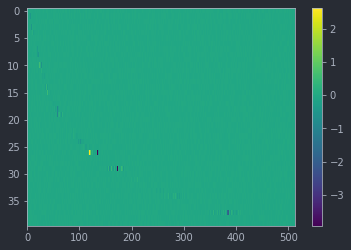

In [327]:
plt.imshow(net2.fc1.weight.detach().numpy(), aspect='auto')
plt.colorbar()

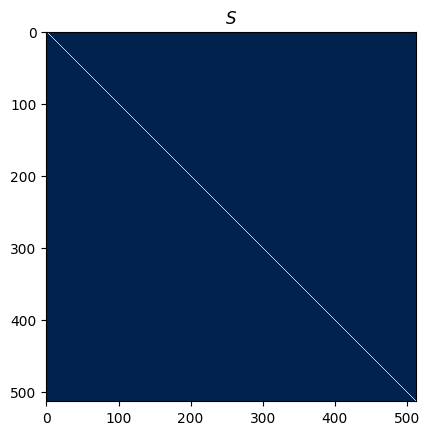

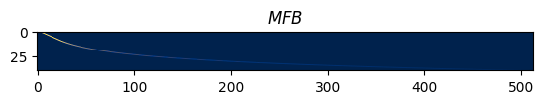

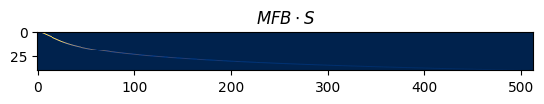

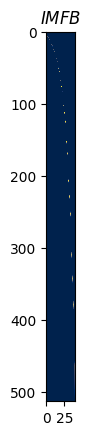

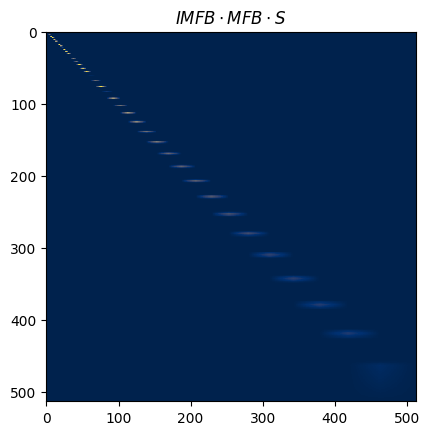

In [387]:
with plt.style.context('default'):

    cmap = 'cividis'
    aspect = 1

    spec = np.eye(513)

    mel_basis = librosa.filters.mel(sr=44100, n_fft=1024, n_mels=40)

    inverse = librosa.util.nnls(mel_basis, np.eye(40))

    # fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(24,4))
    plt.imshow(spec, cmap=cmap, aspect=aspect)
    plt.title(r'$S$')
    plt.show()
    plt.imshow(mel_basis, cmap=cmap, aspect=aspect)
    plt.title(r'$MFB$')
    plt.show()
    plt.imshow(mel_basis.dot(spec), cmap=cmap, aspect=aspect)
    plt.title(r'$MFB \cdot S$')
    plt.show()
    plt.imshow(inverse, cmap=cmap, aspect=aspect)
    plt.title(r'$IMFB$')
    plt.show()
    plt.imshow(inverse.dot(mel_basis).dot(spec), cmap=cmap, aspect=aspect)
    plt.title(r'$IMFB \cdot MFB \cdot S$')
    plt.show()

In [388]:
mel_basis.min(), mel_basis.max()

(0.0, 0.009978338)

In [389]:
inverse.min(), inverse.max()

(0.0, 332.24393)